## 

In [8]:
import torch
from torch import nn

class OneDimMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),  # t埋め込みを考慮して入力次元を +1
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # 出力は1次元
        )
    
    def forward(self, x, t):
        # tをログスケールで簡易的に埋め込む (1Dデータに適用)
        t_embed = torch.log1p(t.float()).unsqueeze(1)  # tを(バッチサイズ, 1)に変換
        x_t = torch.cat([x, t_embed], dim=1)  # xとt_embedを結合
        return self.model(x_t)

# モデル作成
input_dim = 3  # 入力次元 (例: xは3次元データ)
hidden_dim = 32  # 隠れ層のユニット数
model = OneDimMLP(input_dim=input_dim, hidden_dim=hidden_dim)

# テスト用データ
x = torch.randn(10, input_dim)  # 10個の3次元の入力
t = torch.randint(1, 100, (10,))  # 10個の時間ステップ (整数)
y = model(x, t)  # 順伝播
print(y.shape)  # (10, 1)


torch.Size([10, 1])


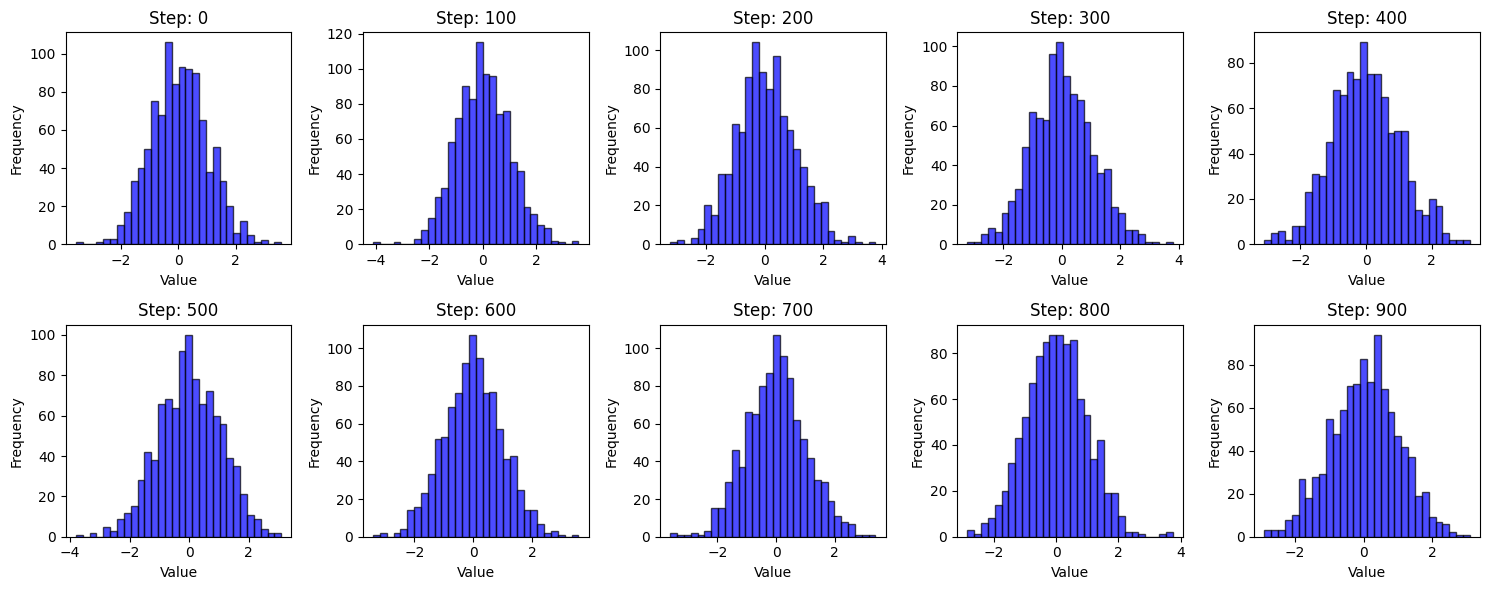

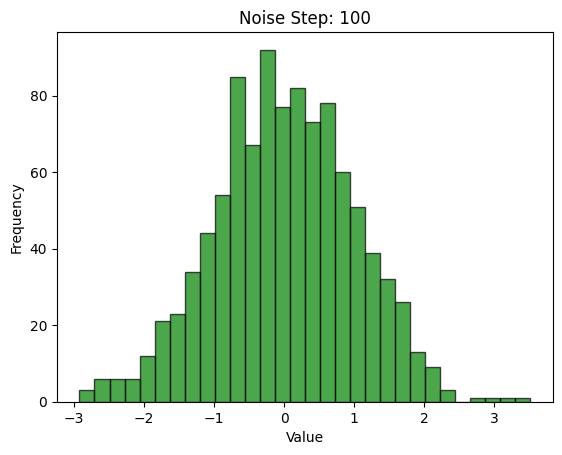

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# シードの設定
torch.cuda.manual_seed(42)

# 1D正規乱数データの作成 (GPU上に転送)
x = torch.randn(1000, device='cuda')  # 1Dデータ (サンプル数: 1000)

# ノイズステップ数とベータスケジュールの設定
T = 1000
betas = torch.linspace(0.0001, 0.02, T, device='cuda')  # betasもGPU上に置く

# ノイズを追加するプロセス
for t in range(T):
    beta = betas[t]
    eps = torch.randn_like(x)  # xと同じ形状のノイズを生成
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

# 元の1D正規分布データを保持
original_x = torch.randn(1000, device='cuda')  # GPU上に元のデータも作成

# 可視化: ノイズが加わる様子を表示
samples = []

for t in range(T):
    if t % 100 == 0:
        samples.append(x.clone().cpu().numpy())  # GPUからCPUに転送して保存

    beta = betas[t]
    eps = torch.randn_like(x)
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

# ノイズステップごとのデータを可視化
plt.figure(figsize=(15, 6))
for i, sample in enumerate(samples[:10]):
    plt.subplot(2, 5, i + 1)
    plt.hist(sample, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f"Step: {i * 100}")
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# ============================================
# q(x_t|x_0) 関数の1Dバージョン (CUDA対応)
# ============================================
def add_noise(x_0, t, betas):
    T = len(betas)
    assert t >= 1 and t <= T
    t_idx = t - 1  # betas[0]はt=1用

    # アルファバーの計算
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    alpha_bar = alpha_bars[t_idx]

    eps = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * eps
    return x_t

# 特定のステップでのノイズ付加
x = original_x
t = 100
x_t = add_noise(x, t, betas)

# 結果をヒストグラムで表示
plt.hist(x_t.cpu().numpy(), bins=30, alpha=0.7, color='green', edgecolor='black')  # GPUからCPUに転送
plt.title(f"Noise Step: {t}")
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
